# **Clustering**

El primer paso es realizar un análisis de segmentación para agrupar clientes o productos según características clave.

In [1]:
%load_ext autoreload
%autoreload 2


# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append("../../")
from src import funciones_eda as fe
from src import soporte_clustering as sc
from src import funciones_encoding as fen
from src import funciones_outliers as fo
from src import funciones_estandarizacion as fes

pd.set_option("display.max_columns", None)

In [35]:
df_original = pd.read_csv("../../datos/Global_Superstore.csv", encoding="latin1")
df_original.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


Observamos que no hay dupolicados y la única columna que tiene nulos es Postal Code:

In [36]:
print(f"Hay {df_original.duplicated().sum()} duplicados.")
df_original.isna().sum()

Hay 0 duplicados.


Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Vamos a eliminar las columnas que no aportan valor a la hora de segmentar los clientes. Entre ellas la columna que consideramos más importante es `Profit` pues nosotros como empresa lo que vamos a intentar es segmentar a nuestros clientes en base al dinero que nos están generando como empresa.

In [37]:
df_clustering = df_original[['Market', 'Category', 'Sales', 'Profit']]

In [38]:
fe.exploracion_dataframe(df_clustering)

El número de datos es 51290 y el de columnas es 4

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 10031

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Market,object
Category,object
Sales,float64
Profit,float64



 ..................... 



,count,mean,std,min,25%,50%,75%,max
Sales,51290.0,246.490581,487.565361,0.444,30.758625,85.053,251.0532,22638.480
Profit,51290.0,28.610982,174.340972,-6599.978,0.000000,9.240,36.8100,8399.976



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna MARKET tiene las siguientes valore únicos:


,count
Market,
APAC,11002
LATAM,10294
EU,10000
US,9994
EMEA,5029


La columna CATEGORY tiene las siguientes valore únicos:


,count
Category,
Office Supplies,31273
Technology,10141
Furniture,9876


Podemos observar que han aparecido duplicados debido a que hemos eliminado numerosas columnas, sin embargo, esos duplicados corresponden a datos reales por lo que los mantenemos. 

Vemos que tanto la media como mediana de las variables numéricas difieren bastante siendo en Sales 85 la mediana y 246 la media, lo que implica que hay alguno valores muy muy altos que distorsionan la media, lo mismo ocurre con Profit.

### 1. Visualizar numéricas y categóricas.

In [6]:
sop_clust = sc.Exploracion(df_clustering)

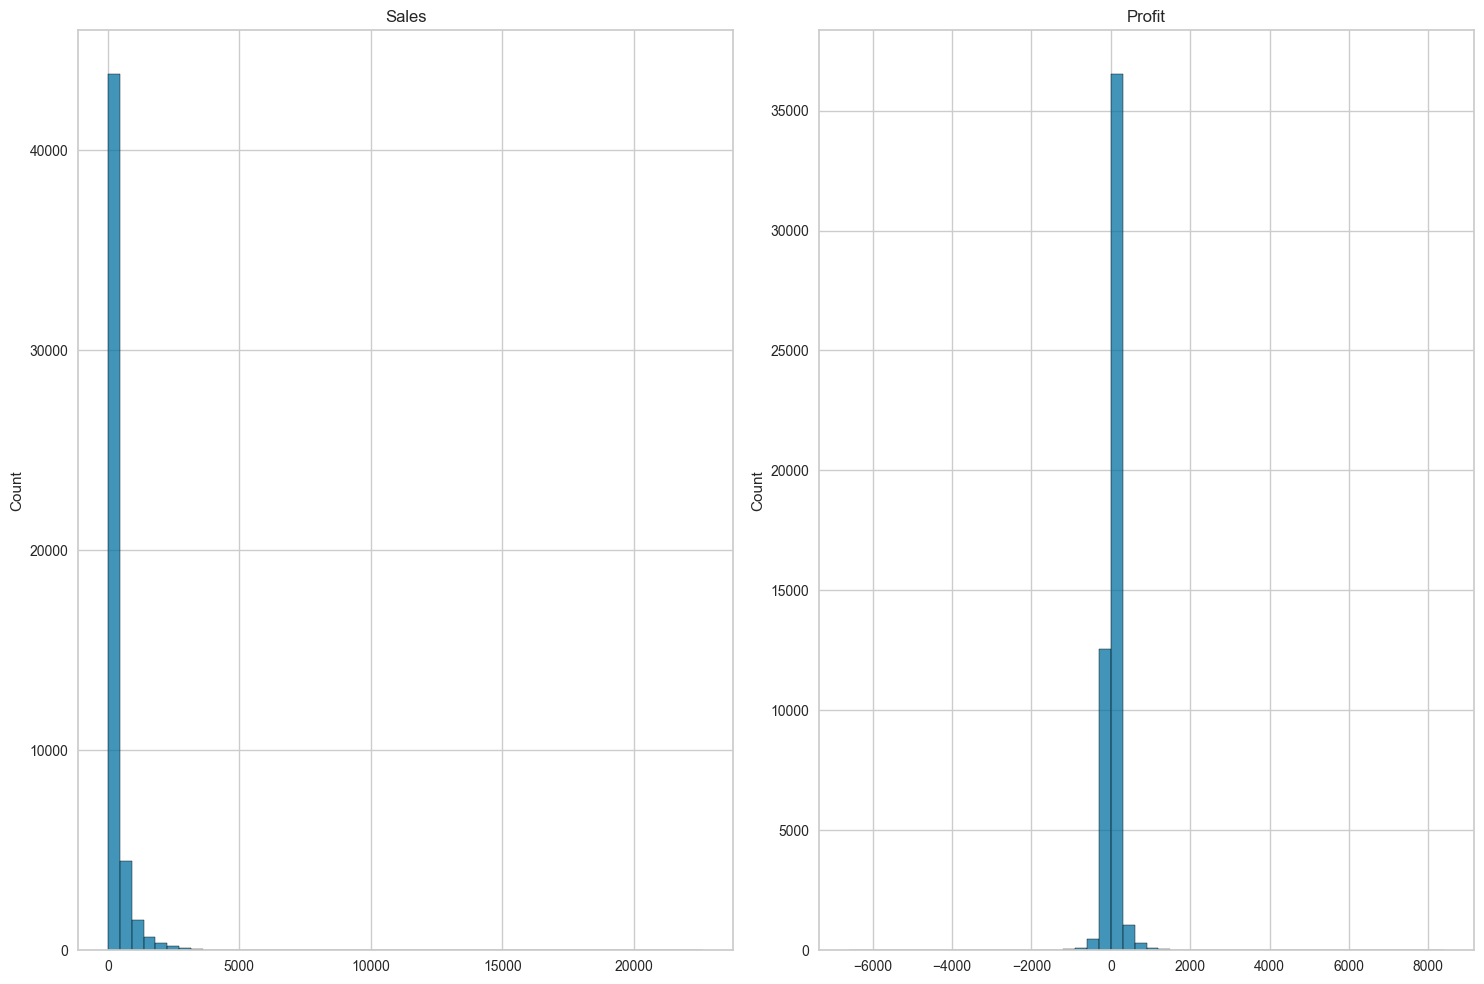

In [7]:
df_num, df_cat = fe.separar_df(df_clustering)
fe.plot_numericas(df_num)

Podemos observar gráficamente lo que acabamos de comentar sobre la media y la mediana y como hay valores donde hay muchísimo más peso que en otras haciendo que la media sea poco fiable.

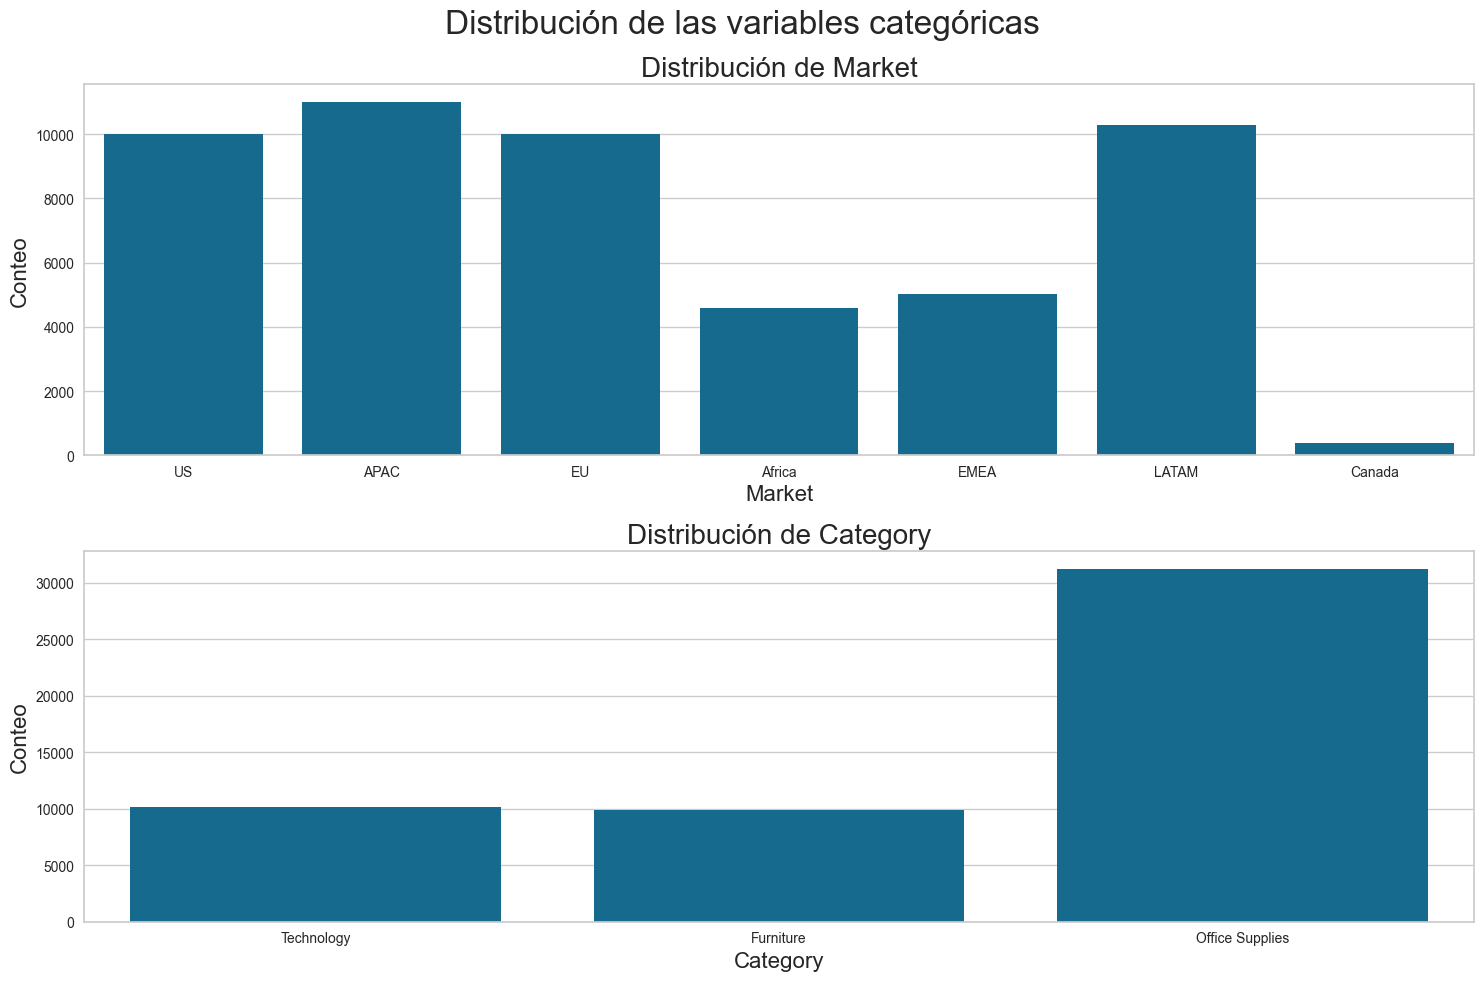

In [8]:
sop_clust.visualizar_categoricas()

En cuanto a las variables categóricas podemos ver que en Segment la variable consumer es la dominante, en cuanto a paises claramente hay muchísimos más clientes de Estados Unidos que de otros paises lo que puede generarnos demasiados clusters debido a sus distintos hábitos de compra. En cuanto a Category la más vendidad es Office Supllies y en cuanto a Order Priority la más usada es medium seguida de high.

### 2. Correlación entre variables numéricas

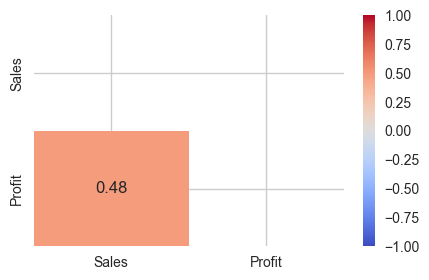

In [9]:
fe.heatmap_correlacion(df_clustering, figsize=(5,3))

La correlación entre Sales y Profit es mediana, de hecho estudiando los datos la categoría que más sales genera es la que menos profit da, no en todas es así, pero es una buena observación para entender porque la correlación no es más alta.

### 3. Outliers

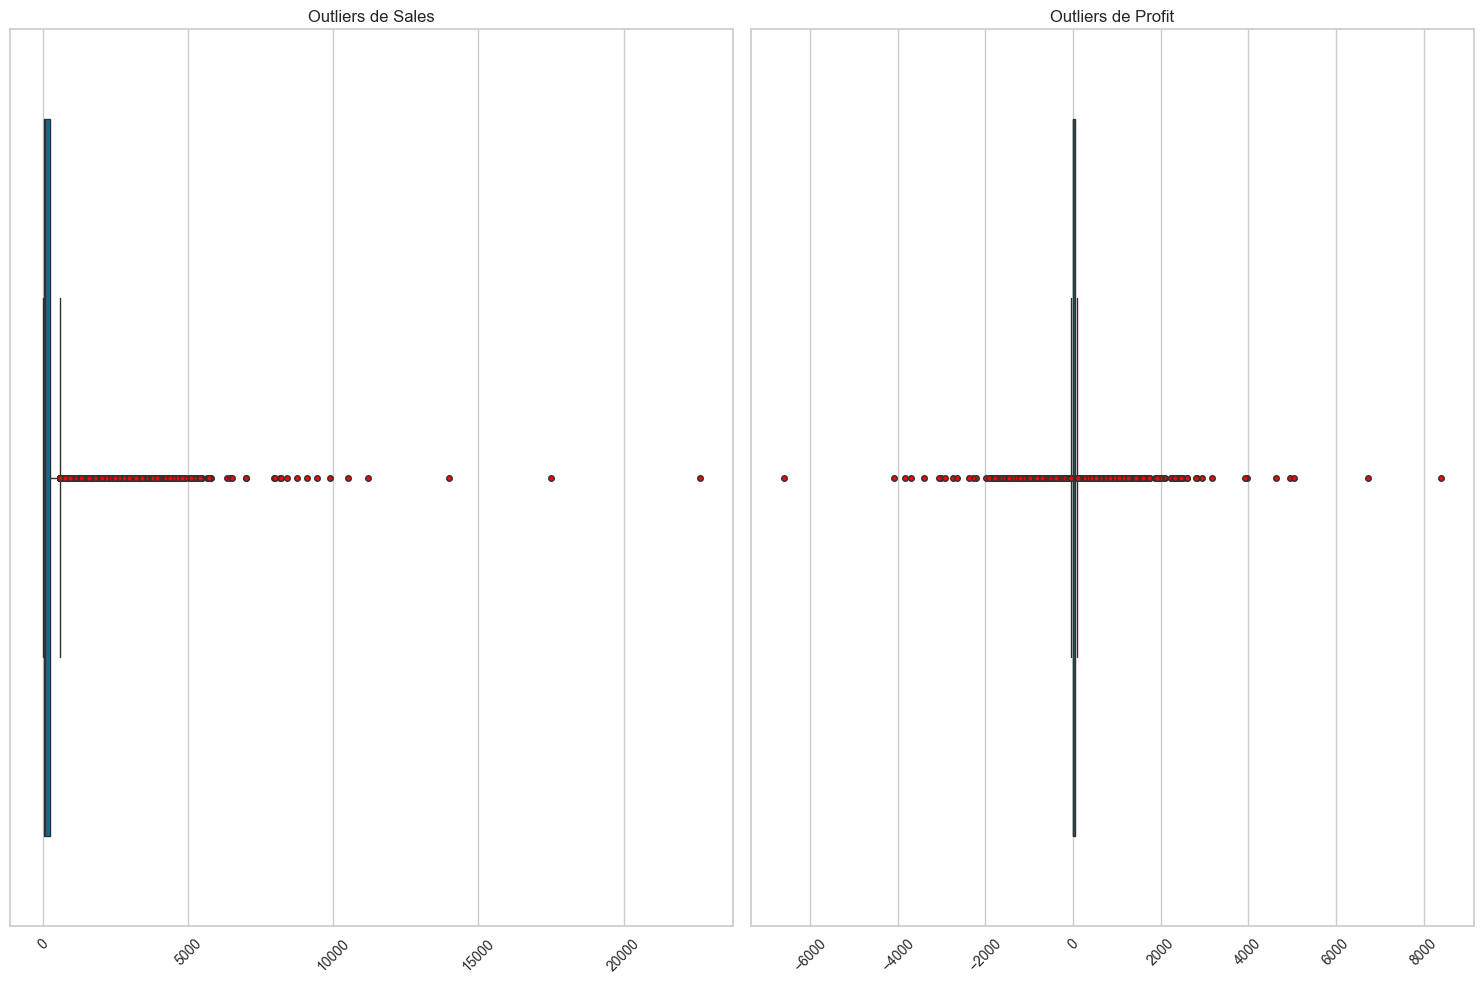

In [10]:
fe.detectar_outliers(df_clustering)

In [11]:
multi = fo.GestionOutliersMultivariados(df_clustering)
contaminacion = [0.01, 0.05, 0.1]
estimadores = [10, 100, 200]
cols = df_num.columns
vr = ""
df_outliers = multi.detectar_outliers_if(cols, vr, contaminacion, estimadores, False)

In [12]:
df_outliers["porcentaje_outliers"] = df_outliers.filter(like="outliers").apply(lambda x: round(sum(x==-1)/len(x),2), axis=1)

porcentaje = 0.6
df_outliers_porcentaje = df_outliers[df_outliers["porcentaje_outliers"]>porcentaje]
df_restante = df_outliers[df_outliers["porcentaje_outliers"]<porcentaje]

print(f"Tenemos un {round(df_outliers_porcentaje.shape[0]/df_outliers.shape[0]*100, 2)}% de outliers respecto al total de los datos.")

Tenemos un 4.46% de outliers respecto al total de los datos.


In [13]:
df_outliers_porcentaje.shape[0]

2289

In [14]:
df_outliers_porcentaje.describe().T[:2]

,count,mean,std,min,25%,50%,75%,max
Sales,2289.0,1737.307585,1307.948010,63.474,959.760,1564.5600,2182.68,22638.480
Profit,2289.0,164.083378,748.850891,-6599.978,-324.864,309.4515,553.98,8399.976


In [15]:
df_outliers_porcentaje["Category"].value_counts()


Category
Technology         946
Furniture          884
Office Supplies    459
Name: count, dtype: int64

Observando los outlies al fin y al cabo son datos reales y tampoco deberíamos eliminarlos a la ligera por lo que como primera aproximación nos los quedamos.

In [16]:
df_inicial = df_clustering.copy()

In [17]:
df_inicial.to_pickle("../../datos/dataframes/df_inicial.pkl")

## **Preprocesamiento**

### Encoding

In [18]:
df_clustering.head(1)

,Market,Category,Sales,Profit
0,US,Technology,2309.65,762.1845


In [19]:
diccionario_encoding={"frequency":['Category', 'Market']}
var = "Profit"
encoding = fen.Encoding(df_clustering, diccionario_encoding, var)


# df_ohe, one_hot_encoder = encoding.one_hot_encoding()
# df_ohe.drop(columns=diccionario_encoding["onehot"], inplace=True)
# df_ohe

df_scaled = encoding.frequency_encoding()
df_scaled.head(3)


,Market,Category,Sales,Profit
0,0.194853,0.197719,2309.650,762.1845
1,0.214506,0.192552,3709.395,-288.7650
2,0.214506,0.197719,5175.171,919.9710


In [20]:
df_scaled.to_pickle("../../datos/dataframes/df_clustering_encoded.pkl")

### Estandarizacion

In [21]:
df_clustering_encoded = pd.read_pickle("../../datos/dataframes/df_clustering_encoded.pkl")

In [22]:
modelos_estand = ["standar", "robust", "minmax"]

df_estand, dic_scaler = fes.estandarizacion(df_clustering_encoded, df_clustering_encoded.columns, modelos_estand)
df_estand.head()

,Market,Category,Sales,Profit,Market_standar,Category_standar,Sales_standar,Profit_standar,Market_robust,Category_robust,Sales_robust,Profit_robust,Market_minmax,Category_minmax,Sales_minmax,Profit_minmax
0,0.194853,0.197719,2309.650,762.1845,0.329872,-1.237284,4.231596,4.207735,-0.020000,-1.00000,10.098283,20.454890,0.905067,0.012385,0.102006,0.490812
1,0.214506,0.192552,3709.395,-288.7650,0.764681,-1.262832,7.102511,-1.820450,3.340000,-1.01254,16.452253,-8.095762,1.000000,0.000000,0.163837,0.420749
2,0.214506,0.197719,5175.171,919.9710,0.764681,-1.237284,10.108857,5.112790,3.340000,-1.00000,23.105962,24.741402,1.000000,0.012385,0.228586,0.501331
3,0.194970,0.197719,2892.510,-96.5400,0.332460,-1.237284,5.427057,-0.717859,0.000000,-1.00000,12.744104,-2.873676,0.905632,0.012385,0.127753,0.433564
4,0.089433,0.197719,2832.960,311.5200,-2.002483,-1.237284,5.304919,1.622750,-18.043333,-1.00000,12.473784,8.211899,0.395837,0.012385,0.125122,0.460768


In [23]:
scaler="minmax"
df_scaled = df_estand.loc[:, df_estand.columns.str.contains(f"{scaler}", case=False)]
df_scaled.columns = df_scaled.columns.str.replace(f"_{scaler}", "", regex=False)

df_scaled.head(2)


,Market,Category,Sales,Profit
0,0.905067,0.012385,0.102006,0.490812
1,1.000000,0.000000,0.163837,0.420749


In [24]:
df_scaled.to_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")

# **Modelos de clustering**

## **K-MEANS**

In [25]:
df = pd.read_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../../datos/dataframes/df_inicial.pkl")

df.head()

,Market,Category,Sales,Profit
0,0.905067,0.012385,0.102006,0.490812
1,1.000000,0.000000,0.163837,0.420749
2,1.000000,0.012385,0.228586,0.501331
3,0.905632,0.012385,0.127753,0.433564
4,0.395837,0.012385,0.125122,0.460768


In [26]:
clust = sc.Clustering(df)
#clust.sacar_clusters_kmeans()

In [27]:
k=3
df_kmeans, labels = clust.modelo_kmeans(df, k)
display(df_kmeans.head())
clust.calcular_metricas(labels)

,Market,Category,Sales,Profit,clusters_kmeans
0,0.905067,0.012385,0.102006,0.490812,1
1,1.000000,0.000000,0.163837,0.420749,1
2,1.000000,0.012385,0.228586,0.501331,1
3,0.905632,0.012385,0.127753,0.433564,1
4,0.395837,0.012385,0.125122,0.460768,1


,silhouette_score,davies_bouldin_index,cardinalidad
0,0.926923,0.13284,"{0: 24654, 1: 20017, 2: 6619}"


In [28]:
df_inicial["cluster_kmean"]=df_kmeans["clusters_kmeans"]
df_inicial.head()

,Market,Category,Sales,Profit,cluster_kmean
0,US,Technology,2309.650,762.1845,1
1,APAC,Furniture,3709.395,-288.7650,1
2,APAC,Technology,5175.171,919.9710,1
3,EU,Technology,2892.510,-96.5400,1
4,Africa,Technology,2832.960,311.5200,1


columna: Market
columna: Category
columna: cluster_kmean


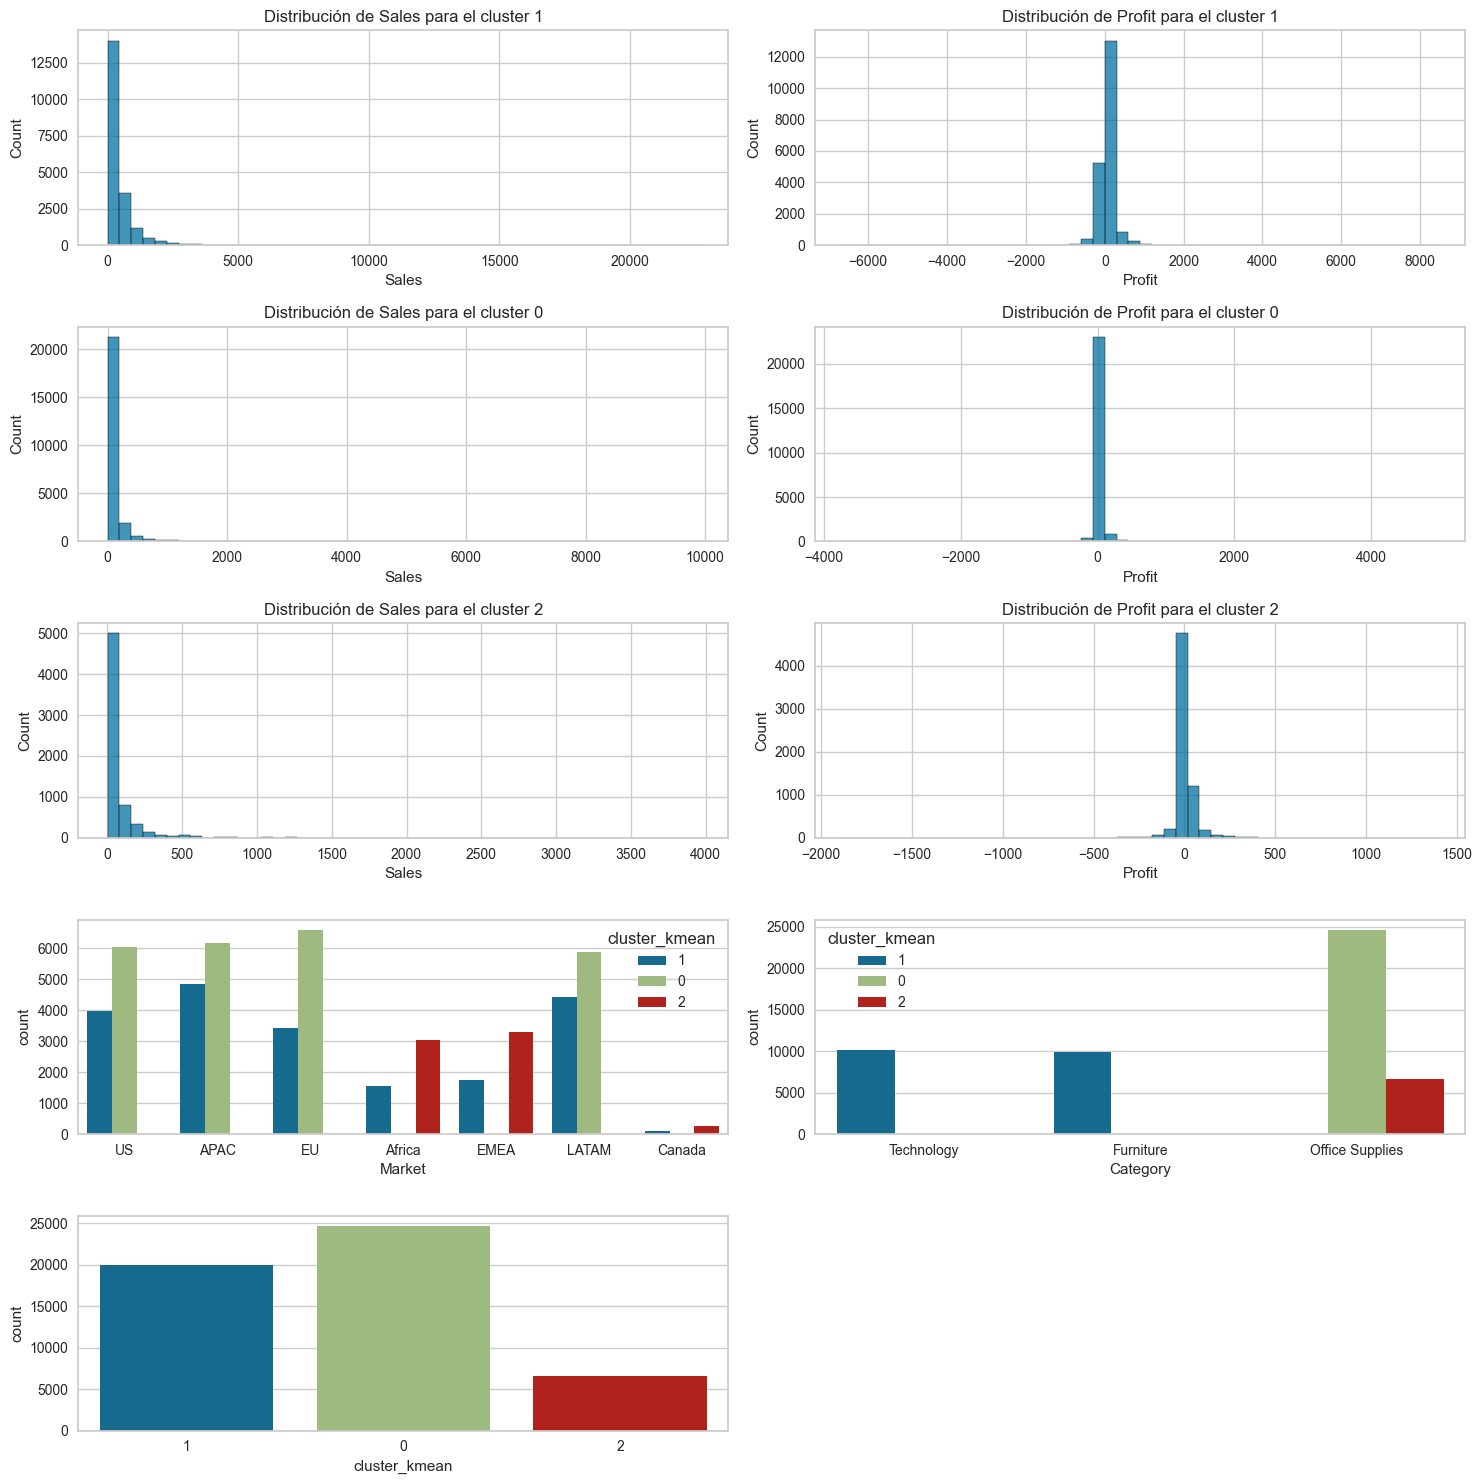

In [29]:
#clust.plot_clusters()
clust.show_cols_clusters(df_inicial, "cluster_kmean")

In [30]:
for cluster in sorted(df_inicial["cluster_kmean"].unique()):
    print(f"Cluster {cluster}:")
    display(df_inicial[df_inicial["cluster_kmean"]==f"{cluster}"].describe().T)

Cluster 0:


,count,mean,std,min,25%,50%,75%,max
Sales,24654.0,130.347798,320.226907,0.4440,22.686,49.8000,112.92,9892.74
Profit,24654.0,18.948928,116.052973,-3701.8928,0.780,7.2576,22.05,4946.37


Cluster 1:


,count,mean,std,min,25%,50%,75%,max
Sales,20017.0,442.395548,637.346442,0.990,103.3461,244.56,529.900,22638.480
Profit,20017.0,47.408875,241.838082,-6599.978,-5.4040,21.90,83.733,8399.976


Cluster 2:


,count,mean,std,min,25%,50%,75%,max
Sales,6619.0,86.640823,199.631387,1.161,14.3955,30.54,78.12,3955.14
Profit,6619.0,7.751469,81.519996,-1869.876,-2.2440,4.62,15.36,1383.90


El modelo obtenido genera tres clusters {0: 24654, 1: 20017, 2: 6619}

La división de los custers de nuevo se hace en función de Category donde el cluster 1 abarca Technology y furniture y el cluster 0 y 1 se dividen Office supplies.

Adeás en cuanto a mercados el cluster dos solo abarca Africa, EMEA y un pooc de Canadá.

Viendo el Profit de cada cluster el clustar 0 va de -3700 a 5000, cluster 1 de -6500 a 8400 y cluster 2 de -2000 a 1400.
Por lo que de nuevo, en cuanto a profit el cluster 1 tiene un rango muy amplio, sin embargo, tiene sentido pues abarca dos de las tres categorías de producto.

Finalmente, como se explica en el  .txt este es el modelo de clustering elegido, por lo que dividimos el dataframe.

In [39]:
df_original["cluster"]=df_kmeans["clusters_kmeans"]
df_original.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,cluster
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,1
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,1
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,1
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,1
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,1


In [40]:
for cluster in sorted(df_original["cluster"].unique()):
    print(f"Guardando cluster {cluster} ...")
    df_aux = df_original[df_original["cluster"]==f"{cluster}"]
    print(df_aux.shape)
    df_aux.to_pickle(f"../../datos/dataframes/df_cluster_{cluster}.pkl")

Guardando cluster 0 ...
(24654, 25)
Guardando cluster 1 ...
(20017, 25)
Guardando cluster 2 ...
(6619, 25)


## **DBSCAN**

In [ ]:
df = pd.read_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../../datos/dataframes/df_inicial.pkl")

df.head()

,Market,Category,Sales,Profit
0,0.905067,0.012385,0.102006,0.490812
1,1.000000,0.000000,0.163837,0.420749
2,1.000000,0.012385,0.228586,0.501331
3,0.905632,0.012385,0.127753,0.433564
4,0.395837,0.012385,0.125122,0.460768


In [139]:
cluster = sc.Clustering(df)

In [142]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[2000])

Todos los puntos son ruido o están en el mismo cluster


In [143]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[1000])

Todos los puntos son ruido o están en el mismo cluster


In [146]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5, 1.0, 1.5, 2.0], min_samples_values=[500, 1000, 2000, 5000, 10000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality,num_clusters
0,0.5,500,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
1,0.5,1000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
2,0.5,2000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
3,0.5,5000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
4,0.5,10000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
5,1.0,500,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
6,1.0,1000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
7,1.0,2000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
8,1.0,5000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3
9,1.0,10000,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3


best_eps: 0.5, best_min_samples: 500


In [147]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5], min_samples_values=[500])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality,num_clusters
0,0.5,500,0.859681,0.333821,"{-1: 2, 0: 20015, 1: 31273}",3


best_eps: 0.5, best_min_samples: 500


In [148]:
df_cluster_dbscan

,Market,Category,Sales,Profit,clusters_dbscan
0,0.905067,0.012385,0.102006,0.490812,0
1,1.000000,0.000000,0.163837,0.420749,0
2,1.000000,0.012385,0.228586,0.501331,0
3,0.905632,0.012385,0.127753,0.433564,0
4,0.395837,0.012385,0.125122,0.460768,0
...,...,...,...,...,...
51285,1.000000,1.000000,0.002856,0.440300,1
51286,0.905067,1.000000,0.000000,0.439926,1
51287,0.905067,1.000000,0.000993,0.440749,1
51288,0.933321,1.000000,0.000574,0.440160,1


In [150]:
df_inicial["clusters_dbscan"]=df_cluster_dbscan["clusters_dbscan"]
df_inicial.head()

,Market,Category,Sales,Profit,clusters_dbscan
0,US,Technology,2309.650,762.1845,0
1,APAC,Furniture,3709.395,-288.7650,0
2,APAC,Technology,5175.171,919.9710,0
3,EU,Technology,2892.510,-96.5400,0
4,Africa,Technology,2832.960,311.5200,0


columna: Market
columna: Category


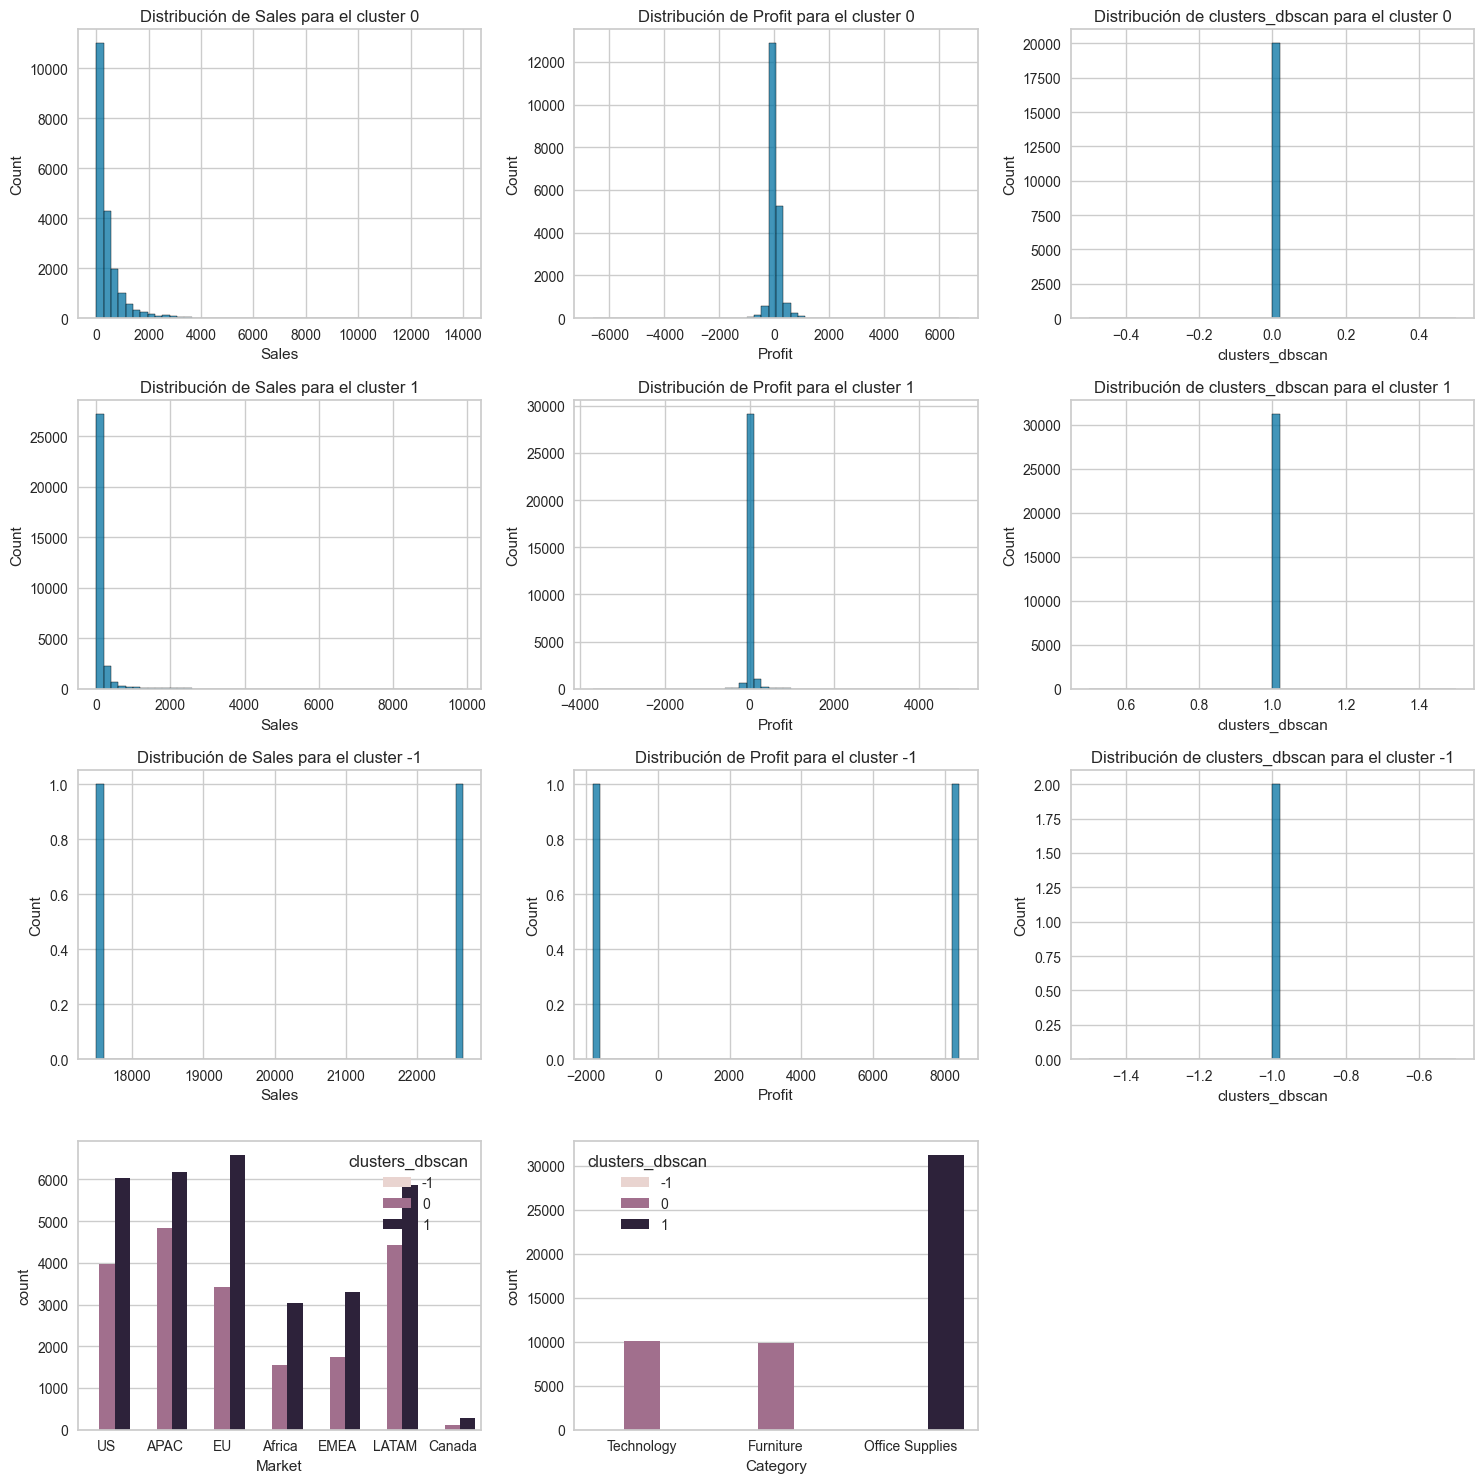

In [151]:
cluster.show_cols_clusters(df_inicial, "clusters_dbscan")

In [163]:
for cluster in sorted(df_inicial["clusters_dbscan"].unique()):
    print(f"Cluster {cluster}:")
    display(df_inicial[df_inicial["clusters_dbscan"]==cluster].describe().T)

Cluster -1:


,count,mean,std,min,25%,50%,75%,max
Sales,2.0,20069.2150,3633.489408,17499.9500,18784.5825,20069.2150,21353.8475,22638.480
Profit,2.0,3294.4488,7220.305809,-1811.0784,741.6852,3294.4488,5847.2124,8399.976
clusters_dbscan,2.0,-1.0000,0.000000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000


Cluster 0:


,count,mean,std,min,25%,50%,75%,max
Sales,20015.0,440.434337,605.882269,0.990,103.32405,244.5,529.8000,13999.9600
Profit,20015.0,47.084415,234.164452,-6599.978,-5.38600,21.9,83.7213,6719.9808
clusters_dbscan,20015.0,0.000000,0.000000,0.000,0.00000,0.0,0.0000,0.0000


Cluster 1:


,count,mean,std,min,25%,50%,75%,max
Sales,31273.0,121.097120,299.321405,0.4440,20.34,46.3800,105.24,9892.74
Profit,31273.0,16.578961,109.749251,-3701.8928,0.45,6.5538,20.58,4946.37
clusters_dbscan,31273.0,1.000000,0.000000,1.0000,1.00,1.0000,1.00,1.00


La división de los custers de nuevo se hace en función de Category donde el cluster 1 abarca Office supplies y el 0 recoge Technology y Furniture Category.

En cuanto a mercados esta muy equilibrado entre los clusters.

Viendo el Profit de cada cluster el clustar 0 va de -3700 a 5000, cluster 1 de -6500 a 8400 y cluster 2 de -2000 a 1400.
Por lo que de nuevo, en cuanto a profit el cluster 1 tiene un rango muy amplio, sin embargo, tiene sentido pues abarca dos de las tres categorías de producto.